# Covertype

In [1]:
%load_ext autoreload
import sys
import os
sys.path.append("../../../learning_particle_gradients/")
from jax import config
config.update("jax_debug_nans", False)
from tqdm import tqdm
from jax import config


import jax.numpy as jnp
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd
import scipy
import haiku as hk
    
import utils
import plot
import distributions
import stein
import models
import flows
from itertools import cycle, islice

key = random.PRNGKey(0)

from sklearn.model_selection import train_test_split


from functools import partial
import kernels
import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
sns.set(style='white')

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

import optax

In [2]:
# set up exporting
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
    'pgf.rcfonts': False,
    'axes.unicode_minus': False, # avoid unicode error on saving plots with negative numbers (??)
})

figure_path = "/home/lauro/documents/msc-thesis/thesis/figures/"
# save figures by using plt.savefig('path/to/fig')
# remember that latex textwidth is 5.4in
# so use figsize=[5.4, 4], for example
printsize = [5.4, 4]

In [3]:
%matplotlib inline

# Data

In [4]:
data = scipy.io.loadmat('/home/lauro/code/msc-thesis/wang_svgd/data/covertype.mat')
features = data['covtype'][:, 1:]
features = onp.hstack([features, onp.ones([features.shape[0], 1])]) # add intercept term

labels = data['covtype'][:, 0]
labels[labels == 2] = 0

xx, x_test, yy, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(xx, yy, test_size=0.1, random_state=0)

num_features = features.shape[-1]

In [5]:
batch_size = 128
num_datapoints = len(x_train)
num_batches = num_datapoints // batch_size


def get_batches(x, y, n_steps=num_batches*2, batch_size=batch_size):
    """Split x and y into batches"""
    assert len(x) == len(y)
    assert x.ndim > y.ndim
    n = len(x)
    idxs = onp.random.choice(n, size=(n_steps, batch_size))
    for idx in idxs:
        yield x[idx], y[idx]
#     batch_cycle = cycle(zip(*[onp.array_split(data, len(data)//batch_size) for data in (x, y)]))
#     return islice(batch_cycle, n_steps)

In [6]:
len(features)

581012

In [7]:
num_features

55

In [8]:
num_datapoints

418328

# Model

In [6]:
%autoreload

In [10]:
a0, b0 = 1, 0.01 # hyper-parameters

from jax.scipy import stats, special

In [11]:
# alternative model
def sample_from_prior(key, num=100):
    keya, keyb = random.split(key)
    alpha = random.gamma(keya, a0, shape=(num,)) / b0
    w = random.normal(keyb, shape=(num, num_features))
    return w, np.log(alpha)


def prior_logp(w, log_alpha):
    """
    Returns logp(w, log_alpha) = sum_i(logp(wi, alphai))

    w has shape (num_features,), or (n, num_features)
    similarly, log_alpha may have shape () or (n,)"""
    if log_alpha.ndim == 0:
        assert w.ndim == 1
    elif log_alpha.ndim == 1:
        assert log_alpha.shape[0] == w.shape[0]

    alpha = np.exp(log_alpha)
    logp_alpha = np.sum(stats.gamma.logpdf(alpha, a0, scale=1/b0))
    if w.ndim == 2:
        logp_w = np.sum(vmap(lambda wi, alphai: stats.norm.logpdf(wi, scale=1/np.sqrt(alphai)))(w, alpha))
    elif w.ndim == 1:
        logp_w = np.sum(stats.norm.logpdf(w, scale=1/np.sqrt(alpha)))
    else:
        raise
    return logp_alpha + logp_w


def preds(x, w):
    """returns predicted p(y = 1| x, w)

    x can have shape (n, num_features) or (num_features,).
    w is a single param of shape (num_features,)"""
    return special.expit(x @ w)


def loglikelihood(y, x, w):
    """
    compute log p(y | x, w) for a single parameter w of
    shape (num_features,) and a batch of data (y, x) of
    shape (m,) and (m, num_features)

    log p(y | x, w) = sum_i(logp(yi| xi, w))
    """
    y = ((y - 1/2)*2).astype(np.int32)
    logits = x @ w
    prob_y = special.expit(logits*y)
    return np.sum(np.log(prob_y))


def log_posterior_unnormalized(y, x, w, log_alpha):
    """All is batched"""
    log_prior = prior_logp(w, log_alpha)
    log_likelihood = np.sum(vmap(lambda wi: loglikelihood(y, x, wi))(w))
    return log_prior + log_likelihood


def log_posterior_unnormalized_single_param(y, x, w, log_alpha):
    """y, x are batched, w, log_alpha not. In case I need
    an unbatched eval of the target logp."""
    log_prior = prior_logp(w, log_alpha)
    log_likelihood = loglikelihood(y, x, w)
    return log_prior + log_likelihood


def compute_probs(y, x, w):
    """
    returns P(y_generated==y | x, w)

    y and x are data batches. w is a single parameter
    array of shape (num_features,)"""
    y = ((y - 1/2)*2).astype(np.int32)
    logits = x @ w
    prob_y = special.expit(logits*y)
    return prob_y


@jit
def compute_test_accuracy(w):
    probs = vmap(lambda wi: compute_probs(y_test, x_test, wi))(w)
    probs_y = np.mean(probs, axis=0)
    return np.mean(probs_y > 0.5)


@jit
def compute_train_accuracy(w):
    probs = vmap(lambda wi: compute_probs(y_train, x_train, wi))(w)
    probs_y = np.mean(probs, axis=0)
    return np.mean(probs_y > 0.5)


def ravel(w, log_alpha):
    return np.hstack([w, np.expand_dims(log_alpha, -1)])


def unravel(params):
    if params.ndim == 1:
        return params[:-1], params[-1]
    elif params.ndim == 2:
        return params[:, :-1], np.squeeze(params[:, -1])


def get_minibatch_logp(x, y):
    """
    Returns callable logp that computes the unnormalized target
    log pdf of raveled (flat) params with shape (num_features+1,)
    or shape (n, num_features+1).

    y, x are minibatches of data."""
    assert len(x) == len(y)
    assert x.ndim > y.ndim

    def logp(params):
        """params = ravel(w, log_alpha)"""
        w, log_alpha = unravel(params)
        log_prior = prior_logp(w, log_alpha)
        if w.ndim == 1:
            mean_loglikelihood = loglikelihood(y, x, w)
        elif w.ndim == 2:
            mean_loglikelihood = np.mean(vmap(lambda wi: loglikelihood(y, x, wi))(w))
        else:
            raise
        return log_prior + num_datapoints * mean_loglikelihood # = grad(log p)(theta) + N/n sum_i grad(log p)(theta | x)
    return logp

# Samplers

In [12]:
NUM_EPOCHS = 1
# NUM_VALS = 5*NUM_EPOCHS # number of test accuracy evaluations per run
NUM_VALS = 40
NUM_STEPS = num_batches*NUM_EPOCHS
n_particles = 100

In [13]:
NUM_STEPS

3268

In [14]:
def sample_tv(key):
    return ravel(*sample_from_prior(key, num=n_particles)).split(2)

def run_svgd(key, lr, full_data=False, progress_bar=False):
    key, subkey = random.split(key)
    init_particles = ravel(*sample_from_prior(subkey, n_particles))
#     svgd_opt = optax.chain(optax.scale_by_schedule(utils.polynomial_schedule),
#                            optax.scale_by_rms(),
#                            optax.scale(-lr))
    svgd_opt = optax.sgd(lr)

    svgd_grad = models.KernelGradient(get_target_logp=lambda batch: get_minibatch_logp(*batch), scaled=True)
    particles = models.Particles(key, svgd_grad.gradient, init_particles, custom_optimizer=svgd_opt)

    test_batches = get_batches(x_test, y_test, 2*NUM_VALS) if full_data else get_batches(x_val, y_val, 2*NUM_VALS)
    train_batches = get_batches(xx, yy, NUM_STEPS+1) if full_data else get_batches(x_train, y_train, NUM_STEPS+1)
    for i, batch in tqdm(enumerate(train_batches), total=NUM_STEPS, disable=not progress_bar):
        particles.step(batch)
        if i % (NUM_STEPS//NUM_VALS) == 0:
            test_logp = get_minibatch_logp(*next(test_batches))
            stepdata = {
                "accuracy": compute_test_accuracy(unravel(particles.particles.training)[0]),
                "test_logp": test_logp(particles.particles.training),
            }
            metrics.append_to_log(particles.rundata, stepdata)

    particles.done()
    return particles

In [15]:
lambda_reg = 10**5
# particle_lr = 1e-8 * 2*lambda_reg # 6e-7 is good for sgld
neural_lr = 1e-3 # 6e-2 works surprisingly well

In [16]:
def run_neural_svgd(key, plr, full_data=False, progress_bar=False):
    key, subkey = random.split(key)
    init_particles = ravel(*sample_from_prior(subkey, n_particles))
    nsvgd_opt = optax.sgd(plr)

    key1, key2 = random.split(key)
    neural_grad = models.SDLearner(target_dim=init_particles.shape[1],
                                   get_target_logp=lambda batch: get_minibatch_logp(*batch),
                                   learning_rate=neural_lr,
                                   key=key1,
                                   aux=False,
                                   lambda_reg=lambda_reg)
    particles = models.Particles(key2, neural_grad.gradient, init_particles, custom_optimizer=nsvgd_opt)

    # Warmup on first batch
    neural_grad.train(next_batch=sample_tv,
                      n_steps=100,
                      early_stopping=False,
                      data=next(get_batches(x_train, y_train, n_steps=100+1)))

    next_particles = partial(particles.next_batch)
    test_batches = get_batches(x_test, y_test, 2*NUM_VALS) if full_data else get_batches(x_val, y_val, 2*NUM_VALS)
    train_batches = get_batches(xx, yy, NUM_STEPS+1) if full_data else get_batches(x_train, y_train, NUM_STEPS+1)
    for i, data_batch in tqdm(enumerate(train_batches), total=NUM_STEPS, disable=not progress_bar):
        neural_grad.train(next_batch=next_particles, n_steps=10, data=data_batch)
        particles.step(neural_grad.get_params())
        if i % (NUM_STEPS//NUM_VALS)==0:
            test_logp = get_minibatch_logp(*next(test_batches))
            train_logp = get_minibatch_logp(*data_batch)
            stepdata = {
                "accuracy": compute_test_accuracy(unravel(particles.particles.training)[0]),
                "test_logp": test_logp(particles.particles.training),
                "training_logp": train_logp(particles.particles.training),
            }
            metrics.append_to_log(particles.rundata, stepdata)
    neural_grad.done()
    particles.done()
    return particles, neural_grad

In [17]:
# schedule = utils.polynomial_schedule

def run_sgld(key, lr, full_data=False, progress_bar=False):
    key, subkey = random.split(key)
    init_particles = ravel(*sample_from_prior(subkey, n_particles))
    key, subkey = random.split(key)
#     sgld_opt = utils.scaled_sgld(subkey, lr, schedule)
    sgld_opt = utils.sgld(lr, 0)

    def energy_gradient(data, particles, aux=True):
        """data = [batch_x, batch_y]"""
        xbatch, ybatch = data
        logp = get_minibatch_logp(xbatch, ybatch)
        logprob, grads = value_and_grad(logp)(particles)
        if aux:
            return -grads, {"logp": logprob}
        else:
            return -grads

    particles = models.Particles(key, energy_gradient, init_particles, custom_optimizer=sgld_opt)
    test_batches = get_batches(x_test, y_test, 2*NUM_VALS) if full_data else get_batches(x_val, y_val, 2*NUM_VALS)
    train_batches = get_batches(xx, yy, NUM_STEPS+1) if full_data else get_batches(x_train, y_train, NUM_STEPS+1)
    for i, batch_xy in tqdm(enumerate(train_batches), total=NUM_STEPS, disable=not progress_bar):
        particles.step(batch_xy)
        if i % (NUM_STEPS//NUM_VALS)==0:
            test_logp = get_minibatch_logp(*next(test_batches))
            stepdata = {
                "accuracy": compute_test_accuracy(unravel(particles.particles.training)[0]),
                "train_accuracy": compute_train_accuracy(unravel(particles.particles.training)[0]),
                "test_logp": np.mean(test_logp(particles.particles.training))
            }
            metrics.append_to_log(particles.rundata, stepdata)
    particles.done()
    return particles

# Sweep

In [18]:
key, subkey = random.split(key)


def get_acc(lr, sampler):
    """sampler is one of run_sgld, run_svgd, run_neural_svgd"""
    output = sampler(subkey, lr)
    try:
        acc = output.rundata["accuracy"]
    except AttributeError:
        acc = output[0].rundata["accuracy"]
    return np.mean(np.array(acc[-5:]))


def run_sweep(lrs, sampler):
    accs = []
    for lr in tqdm(lrs):
        accs.append(get_acc(lr, sampler))
    accs = np.array(accs)
    return accs, lrs[np.argmax(accs)]


def plot_accs(lrs, accs, ax=None):
    if ax is None:
        ax = plt.gca()
    accs = np.asarray(accs)
    ax.plot(lrs, accs, "--.")
    ax.set_xscale("log")

lrs = np.logspace(-9, -4, 10)
svgd_lrs = np.logspace(-12, -6, 10)
nsvgd_lrs = np.logspace(-5, -1, 10)

sgld_acc_sweep, sgld_lr = run_sweep(lrs, run_sgld)
svgd_acc_sweep, svgd_lr = run_sweep(lrs, run_svgd)
nsvgd_acc_sweep, nsvgd_lr = run_sweep(nsvgd_lrs, run_neural_svgd)

 20%|██        | 2/10 [00:38<02:32, 19.02s/it]


KeyboardInterrupt: 

In [ ]:
print(sgld_lr, svgd_lr, nsvgd_lr)

In [61]:
print(sgld_lr, svgd_lr, nsvgd_lr)

2.1544354e-06 1.2915498e-08 0.0046415897


In [ ]:
# optimal stepsizes:
# sgld_lr = 2.15e-6
# svgd_lr = 1.29e-8
# ngf_lr = 0.00464

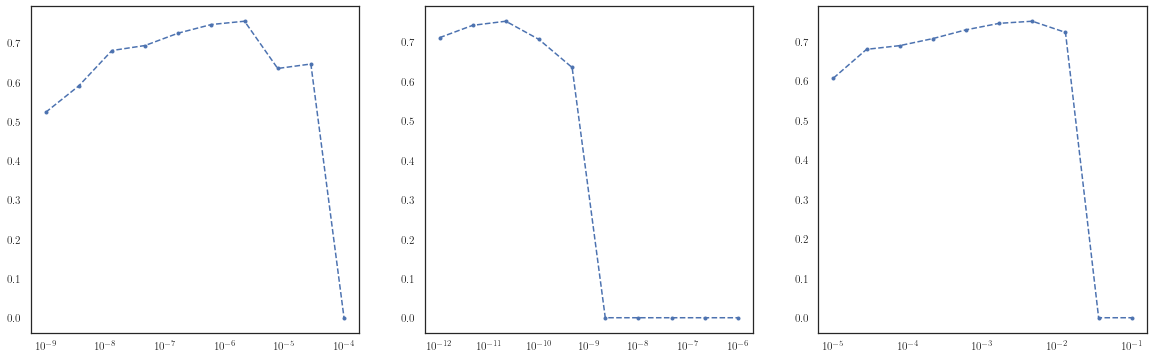

In [25]:
fig, axs = plt.subplots(1, 3, figsize=[20, 6])
plot_accs(lrs, sgld_acc_sweep, ax=axs[0])
plot_accs(svgd_lrs, svgd_acc_sweep, ax=axs[1])
plot_accs(nsvgd_lrs, nsvgd_acc_sweep, ax=axs[2])

# Run samplers with best stepsize

In [ ]:
# Run samplers
# key, subkey = random.split(key)

sgld_p                = run_sgld(       subkey, sgld_lr,  full_data=True, progress_bar=True) # 1e-6
svgd_p                = run_svgd(       subkey, svgd_lr,  full_data=True, progress_bar=True) # 5e-2
neural_p, neural_grad = run_neural_svgd(subkey, nsvgd_lr, full_data=True, progress_bar=True) # 1e-6

In [ ]:
sgld_aux = sgld_p.rundata
svgd_aux = svgd_p.rundata
neural_aux = neural_p.rundata

## run 10 times

In [49]:
def get_run(key, lr, sampler):
    """sampler is one of run_sgld, run_svgd, run_neural_svgd"""
    output = sampler(key, lr, full_data=True)
    try:
        acc = output.rundata["accuracy"]
    except AttributeError:
        acc = output[0].rundata["accuracy"]
    return np.array(acc)


def get_run_avg(key, lr, sampler):
    accs = []
    for _ in tqdm(range(10)):
        key, subkey = random.split(key)
        accs.append(get_run(subkey, lr, sampler))
    accs = np.array(accs)
    return accs.mean(axis=0)


sgld_final = get_run_avg(subkey, sgld_lr, run_sgld)
svgd_final = get_run_avg(subkey, svgd_lr, run_svgd)
ngf_final  = get_run_avg(subkey, nsvgd_lr, run_neural_svgd)

100%|██████████| 10/10 [18:31<00:00, 111.20s/it]


In [53]:
spaced_grid = np.arange(0, NUM_STEPS+1, step=NUM_STEPS // NUM_VALS)

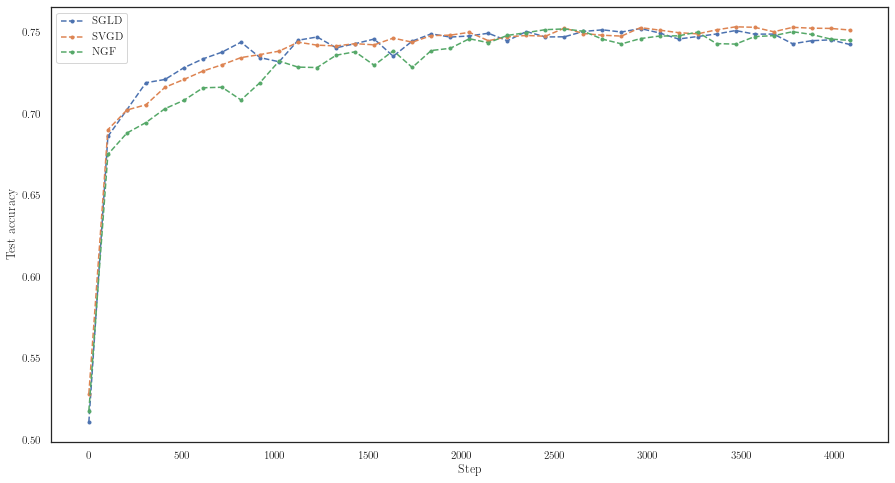

In [54]:
%matplotlib inline
plt.subplots(figsize=[15, 8])
names = ["SGLD", "SVGD", "NGF"]
for name, accuracy in zip(names, (sgld_final, svgd_final, ngf_final)):
    plt.plot(spaced_grid, accuracy, "--.", label=name)

plt.ylabel("Test accuracy")
plt.xlabel("Step")
plt.legend()

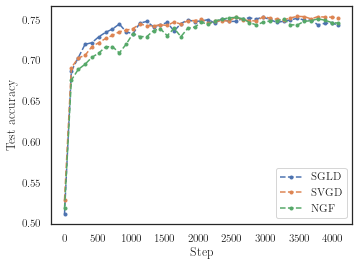

In [55]:
%matplotlib inline
plt.subplots(figsize=printsize)
names = ["SGLD", "SVGD", "NGF"]
for name, accuracy in zip(names, (sgld_final, svgd_final, ngf_final)):
    plt.plot(spaced_grid, accuracy, "--.", label=name)
plt.legend()


plt.ylabel("Test accuracy")
plt.xlabel("Step")

plt.savefig(figure_path + "covtype.pgf")

## Evaluate samples on test set

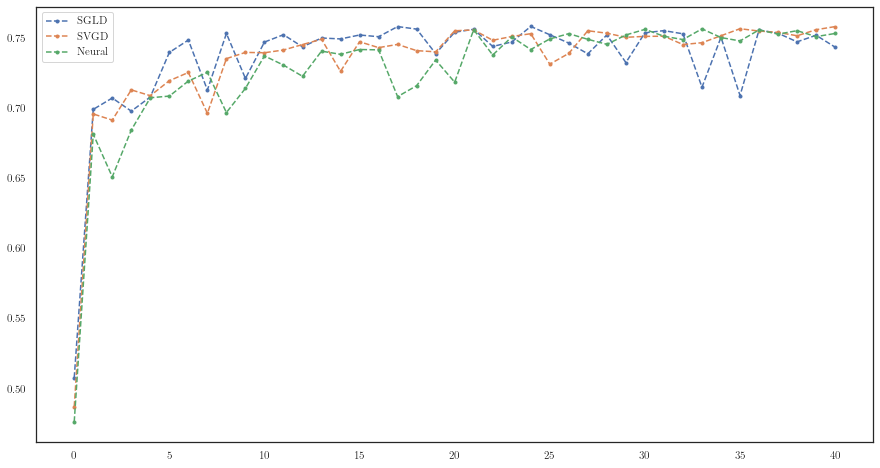

In [29]:
%matplotlib inline
plt.subplots(figsize=[15, 8])
names = ["SGLD", "SVGD", "Neural"]
for name, aux in zip(names, (sgld_aux, svgd_aux, neural_aux)):
    plt.plot(aux["accuracy"], "--.", label=name)
plt.legend()

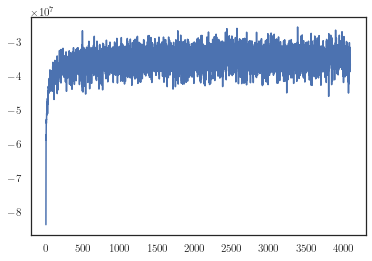

In [30]:
spaced_idx = np.arange(0, NUM_STEPS, NUM_STEPS // NUM_VALS)
plt.plot(sgld_aux["training_logp"])
# plt.plot(spaced_idx, sgld_aux["test_logp"])

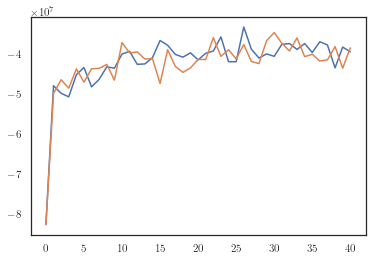

In [31]:
spaced_idx = np.arange(0, NUM_STEPS, NUM_STEPS // NUM_VALS)
plt.plot(neural_aux["training_logp"])
plt.plot(neural_aux["test_logp"])

# neural rundata

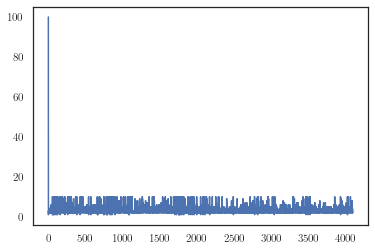

In [32]:
plt.plot(neural_grad.rundata["train_steps"])

In [44]:
%matplotlib widget
# %matplotlib inline
plt.subplots(figsize=[15, 8])
plt.plot(neural_grad.rundata["training_loss"])
plt.plot(neural_grad.rundata["validation_loss"])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

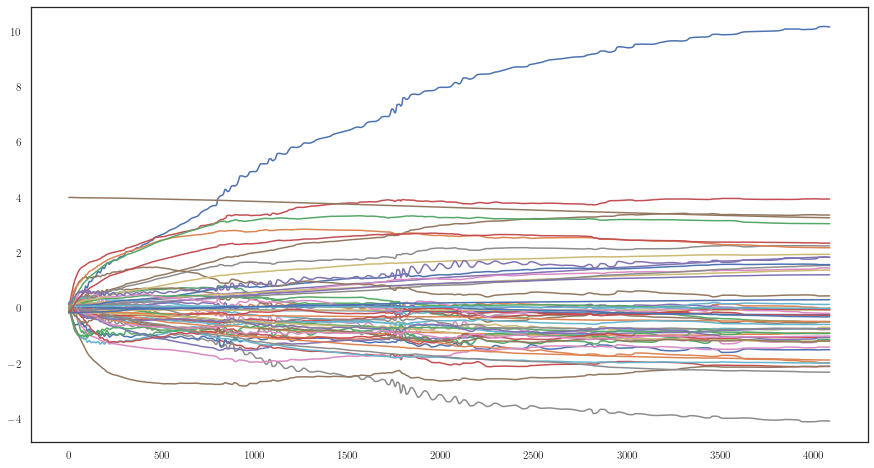

In [45]:
%matplotlib inline
plt.subplots(figsize=[15, 8])
plt.plot(neural_aux["training_mean"]);

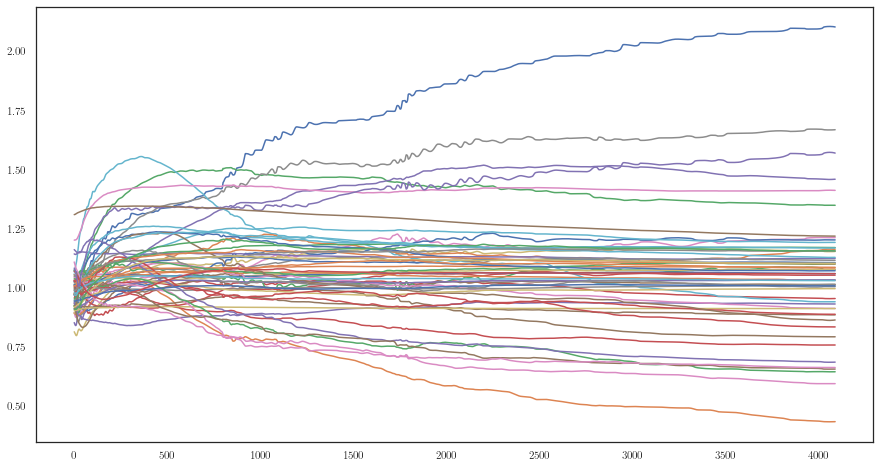

In [46]:
plt.subplots(figsize=[15, 8])
plt.plot(neural_aux["training_std"]);

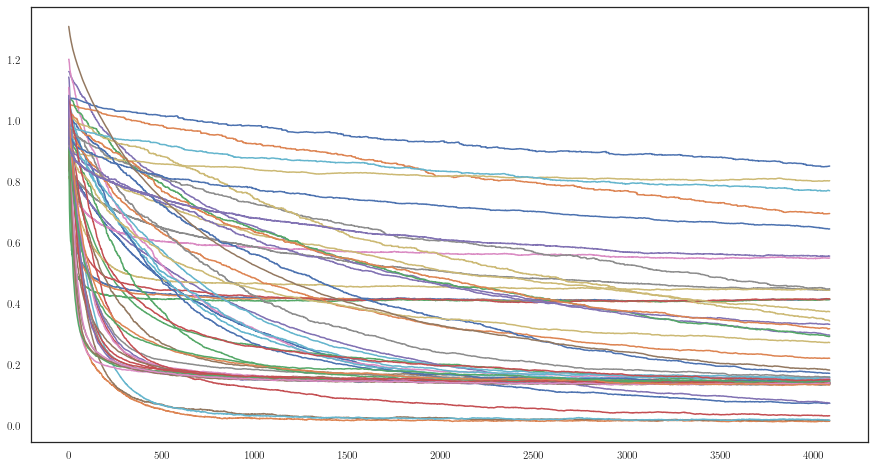

In [47]:
plt.subplots(figsize=[15, 8])
plt.plot(sgld_aux["training_std"]);

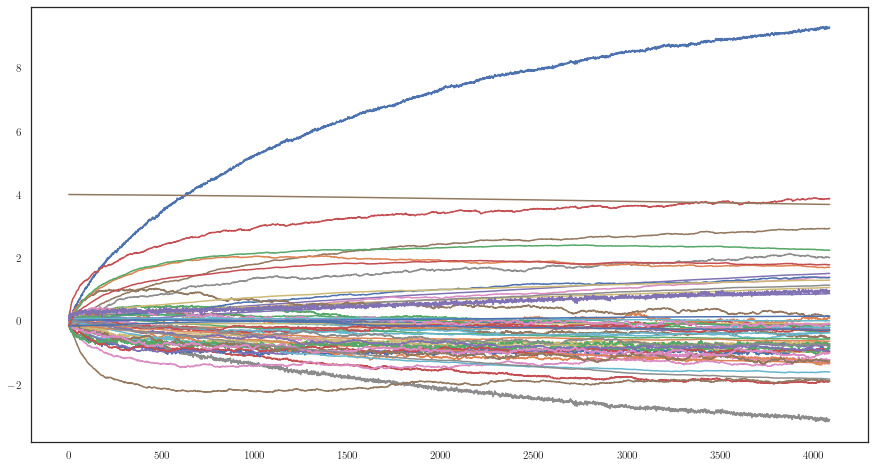

In [48]:
plt.subplots(figsize=[15, 8])
plt.plot(svgd_aux["training_mean"]);

# calibration curve

In [38]:
@jit
def batch_preds(params):
    """Returns test probabilities P(y=1) for
    all y in the test set, for w a parameter array
    of shape (n, num_features)"""
    w, _ = unravel(params)
    probs = vmap(lambda wi: preds(x_test, wi))(w)
    return np.mean(probs, axis=0)

In [39]:
probabilities = [batch_preds(p.particles.training) for p in (sgld_p, svgd_p, neural_p)]

(array([ 6254., 10013., 12974., 14215., 13946., 13576., 12627., 10755.,
         8164., 13679.]),
 array([0.02828849, 0.12528987, 0.22229125, 0.31929263, 0.416294  ,
        0.5132954 , 0.6102968 , 0.70729816, 0.80429953, 0.9013009 ,
        0.9983023 ], dtype=float32),
 <BarContainer object of 10 artists>)

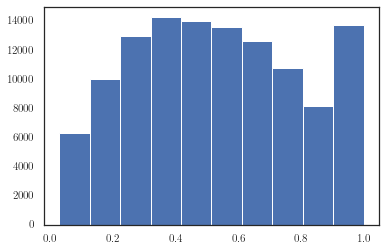

In [40]:
plt.hist(probabilities[2])

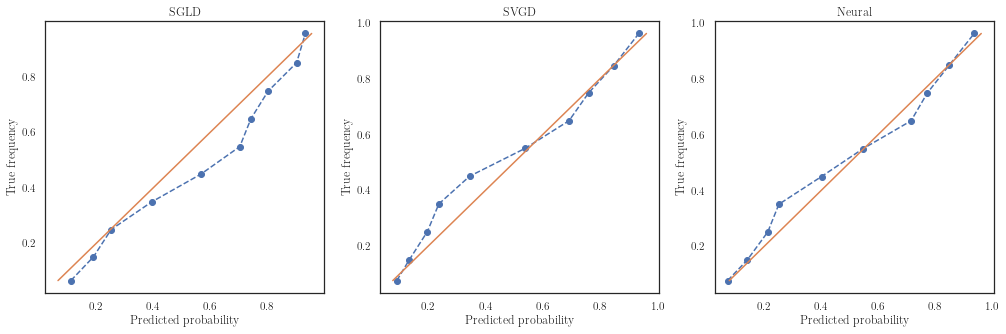

In [41]:
fig, axs = plt.subplots(1, 3, figsize=[17, 5])

for ax, probs, name in zip(axs, probabilities, names):
    true_freqs, bins = calibration_curve(y_test, probs, n_bins=10)
    ax.plot(true_freqs, bins, "--o")
#     print(bins)
    ax.plot(bins, bins)
    ax.set_ylabel("True frequency")
    ax.set_xlabel("Predicted probability")
    ax.set_title(name)

# Plot accuracy vs. certainty

In [36]:
sdlfk

NameError: name 'sdlfk' is not defined

In [ ]:
certainty = np.max([1 - probs, probs])
